# Capítulo 5 - Notebook Único com os Códigos Principais


Você pode rodar este notebook localmente ou no Colab. Para abrir diretamente no Colab, basta clicar no link abaixo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap05/cap05_main.ipynb) 

In [5]:
!mkdir results

## 1. Configurações Iniciais

### Para Rodar no Colab

Nesta versão, você pode rodar a célula abaixo, mesmo sem estar no Colab.

In [2]:
import sys

if 'google.colab' in sys.modules:
    !pip install gym
    !pip install gym[box2d]
    !pip install optuna

    !git clone https://github.com/pablo-sampaio/rl_facil

    !mv /content/rl_facil/cap04/* /content/
    !mv /content/rl_facil/cap05/* /content/

from IPython.display import clear_output

clear_output()

### Imports Gerais

In [1]:
import gym
import numpy as np
import optuna

from util_experiments import test_greedy_Q_policy, repeated_exec
from util_plot import plot_result, plot_multiple_results
from wrappers import DiscreteObservationWrapper, PunishEarlyStop

from montecarlo_v2 import run_montecarlo2
from qlearning import run_qlearning
from expected_sarsa import run_expected_sarsa

## 2. Lidando com Ambientes Contínuos

Vamos usar os mesmos algoritmos de antes, baseados em Q-Table, para lidar com ambientes contínuos. Para isso, vamos usar um wrapper.

Abaixo, nós criamos um ambiente e mostramos o "formato" do seu estado e um exemplo de estado do ambiente.

In [2]:
# 1. Cria o ambiente contínuo
ENV_NAME = "CartPole-v1"
r_max_plot = 200

env = gym.make(ENV_NAME)

# vamos ver como é um estado deste ambiente?
print("Espaço de estados/observações: ", env.observation_space)
print("  - formato: ", env.observation_space.shape)
print("  - exemplo: ", env.reset())

Espaço de estados/observações:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
  - formato:  (4,)
  - exemplo:  [ 0.03537956 -0.02663457 -0.02146765  0.04482837]


d:\Pablo\anaconda3\envs\rlx\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [7]:
# 2. Encapsula o ambiente em nosso wrapper
# atenção para o 2o parâmetro: deve ter um valor para cada componente do estado
env = DiscreteObservationWrapper(env, [20,50,10,20]) 

In [8]:
# 3. Roda um algoritmo de treinamento

EPISODES = 1000
LR = 0.5
GAMMA = 0.95
EPSILON = 0.1

rewards, Qtable = run_expected_sarsa(env, EPISODES, LR, GAMMA, EPSILON, render=False)

print("Últimos resultados: media =", np.mean(rewards[-20:]), ", desvio padrao =", np.std(rewards[-20:]))

Episode 100 Average Reward (last 100): 32.690
Episode 200 Average Reward (last 100): 49.610
Episode 300 Average Reward (last 100): 37.910
Episode 400 Average Reward (last 100): 43.810
Episode 500 Average Reward (last 100): 61.340
Episode 600 Average Reward (last 100): 50.550
Episode 700 Average Reward (last 100): 49.800
Episode 800 Average Reward (last 100): 61.270
Episode 900 Average Reward (last 100): 50.970
Episode 1000 Average Reward (last 100): 59.590
Últimos resultados: media = 80.1 , desvio padrao = 78.9936073362902


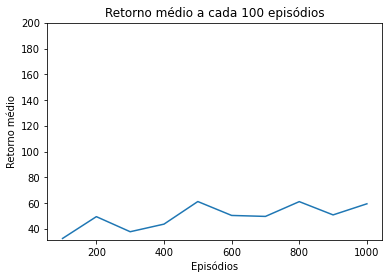

Nenhum arquivo salvo.


In [9]:
# 4. Gera um gráfico de episódios x retornos (não descontados)

filename = f"results/expected_sarsa-{ENV_NAME.lower()[0:8]}-ep{EPISODES}-lr{LR}.png"
plot_result(rewards, r_max_plot, None)

In [10]:
# 5. Faz alguns testes, usando a tabela de forma greedy

test_greedy_Q_policy(env, Qtable, 10, render=False)
env.close()

Retorno médio (por episódio): 54.6, episódios: 10, total de passos: 546


## 3. Otimizando Parâmetros

Vamos usar a biblioteca *Optuna* para otimizar (hiper-)parâmetros dos algoritmos de treinamento.

### Otimizando em um ambiente discreto

Este é o caso mais simples, porque não precisamos aplicar nenhum wrapper.

Primeiro, você precisa fazer uma função que receber um parâmetro "Trial" (objeto do optuna) e retorna uma medida de desempenho. 

Dentro da função, você usa o trial para pedir "sugestões" de valores para os hiper-parâmetros do seu algoritmo.

In [23]:
ENV = gym.make("Taxi-v3")

def train(trial : optuna.Trial):   
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    lr = trial.suggest_uniform('learning_rate', 0.001, 1.0)
    #lr = trial.suggest_loguniform('learning_rate', 0.001, 1.0)
    eps = trial.suggest_uniform('epsilon', 0.01, 0.2)
    
    print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}")

    # roda o algoritmo e recebe os retornos não-descontados
    (returns, _) = run_montecarlo2(ENV, 4000, lr=lr, epsilon=eps)
    
    # limpa a saída da célula do notebook
    clear_output()

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-1000:])/1000 


Depois, você cria um "study" do Optuna e manda otimizar sua função, indicando quantas tentativas (trials) ele vai fazer -- ou seja, quantas vezes a sua função vai ser executada.

In [24]:
study = optuna.create_study(direction='maximize', 
                        storage='sqlite:///resultado_esarsa.db', 
                        study_name='resultado_esarsa',
                        load_if_exists=True)

# maximiza o valor de retorno de train_exp_sarsa, rodando "n_trials" vezes
study.optimize(train, n_trials=15) 

print("MELHORES PARÂMETROS:")
print(study.best_params)

[I 2022-07-21 10:14:15,380] Trial 25 finished with value: 6.56 and parameters: {'learning_rate': 0.37918100089921614, 'epsilon': 0.02753129311804936}. Best is trial 17 with value: 7.99.


MELHORES PARÂMETROS:
{'epsilon': 0.01095238596675123, 'learning_rate': 0.6100081089269185}


### Otimizando em um ambiente contínuo

Neste cao, nós aplicamos o wrapper, que tem novos parâmetros (quantidade de "bins" por valor do estado). 

O wrapper é considerado parte da solução e, por isso, o ideal é tentar otimizar esses parâmetros. Por isso, o wrapper será criado dentro da função a ser otimizada.

In [9]:
# cria apenas a versão contínua
ENV = gym.make("CartPole-v1")

def train_continuous(trial : optuna.Trial):
    
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    lr = trial.suggest_uniform('learning_rate', 0.001, 1.0)
    eps = trial.suggest_uniform('epsilon', 0.01, 0.2)
    bins1 = trial.suggest_int('bins1', 5, 100)
    bins2 = trial.suggest_int('bins2', 5, 100)
    bins3 = trial.suggest_int('bins3', 5, 100)
    bins4 = trial.suggest_int('bins4', 5, 100)
    
    all_bins = [bins1, bins2, bins3, bins4]

    print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}, bins={all_bins}")

    # cria o wrapper e roda o algoritmo, recebendo os retornos não-descontados
    env_wrapper = DiscreteObservationWrapper(ENV, all_bins)
    (returns, _) = run_expected_sarsa(env_wrapper, 4000, lr=lr, epsilon=eps)

    # limpa a saída da célula do notebook
    clear_output()

    # média dos retornos dos últimos 100 episódios
    return sum(returns[-1000:])/1000 


In [11]:
study = optuna.create_study(direction='maximize', 
                        storage='sqlite:///resultado_montecarlo_cont.db', 
                        study_name='resultado_montecarlo_cont',
                        load_if_exists=True)

# maximiza o valor de retorno de train_exp_sarsa_continuous, rodando "n_trials" vezes
study.optimize(train_continuous, n_trials=50) 

print("MELHORES PARÂMETROS:")
print(study.best_params)

[I 2022-07-21 16:44:14,467] Using an existing study with name 'resultado_montecarlo_cont' instead of creating a new one.


MELHORES PARÂMETROS:
{'bins1': 33, 'bins2': 97, 'bins3': 8, 'bins4': 100, 'epsilon': 0.053535584807126176, 'learning_rate': 0.7094982957144118}


## 4. Fazer Experimentos Completos

Agora que você descobriu bons parâmetros, que tal rodar um treinamento mais longo com o seu algoritmo?

Seguem os resultados de otimizações obtidas durante a aula com os alunos.

### Taxi-v3 (discreto)

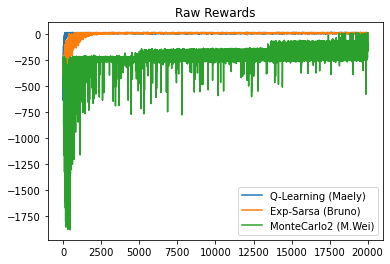

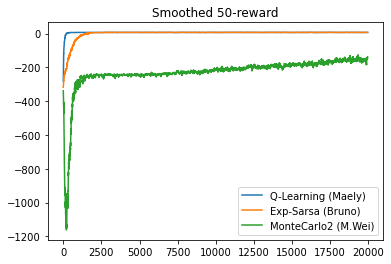

Summary for Q-Learning (Maely)
 - sum rewards (all episodes): 121922.66666666666

Summary for Exp-Sarsa (Bruno)
 - sum rewards (all episodes): 1481.0

Summary for MonteCarlo2 (M.Wei)
 - sum rewards (all episodes): -4607103.666666667



In [2]:
environment = gym.make("Taxi-v3")
NUM_EPISODES = 20000

results = []

# 'epsilon': 0.012630525410678125, 'learning_rate': 0.9189058377450972
results.append( repeated_exec(3, f"Q-Learning (Maely)", run_qlearning, environment, NUM_EPISODES, 0.918, 0.95, 0.012) )
clear_output()

# 'epsilon': 0.01049172026352314, 'learning_rate': 0.07158117429097055
results.append( repeated_exec(3, f"Exp-Sarsa (Bruno)", run_expected_sarsa, environment, NUM_EPISODES, 0.0715, 0.95, 0.010) )
clear_output()

# {'epsilon': 0.07291046034184917, 'learning_rate': 0.025046716210814366}
results.append( repeated_exec(3, f"MonteCarlo2 (M.Wei)", run_montecarlo2, environment, NUM_EPISODES, 0.0250, 0.95, 0.072) )
clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)

### FrozenLake-v1 (discreto)

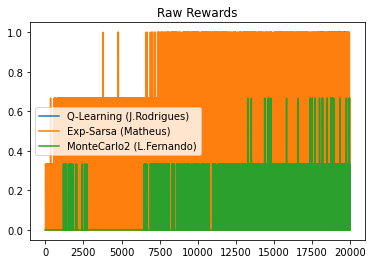

<Figure size 1008x576 with 0 Axes>

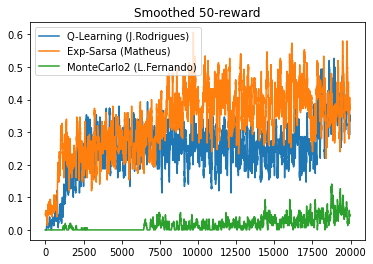

<Figure size 1008x576 with 0 Axes>

Summary for Q-Learning (J.Rodrigues)
 - sum rewards (all episodes): 5000.0

Summary for Exp-Sarsa (Matheus)
 - sum rewards (all episodes): 6624.333333333332

Summary for MonteCarlo2 (L.Fernando)
 - sum rewards (all episodes): 344.3333333333333



In [3]:
environment = gym.make("FrozenLake-v1")
NUM_EPISODES = 20000

results = []

# {'epsilon': 0.03081133375694635, 'learning_rate': 0.5177593676824266}
results.append( repeated_exec(3, f"Q-Learning (J.Rodrigues)", run_qlearning, environment, NUM_EPISODES, 0.517, 0.95, 0.030) )
clear_output()

# 'epsilon': 0.045332160883937794, 'learning_rate': 0.24962062732262033
results.append( repeated_exec(3, f"Exp-Sarsa (Matheus)", run_expected_sarsa, environment, NUM_EPISODES, 0.249, 0.95, 0.045) )
clear_output()

# learning_rate': 0.8054242666287916, 'epsilon': 0.07261114965386482, 'gamma': 2.2849204996994357
results.append( repeated_exec(3, f"MonteCarlo2 (L.Fernando)", run_montecarlo2, environment, NUM_EPISODES, 0.805, 2.28, 0.072) )
clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)

### MountainCar (contínuo)

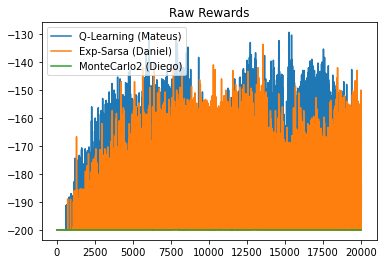

<Figure size 1008x576 with 0 Axes>

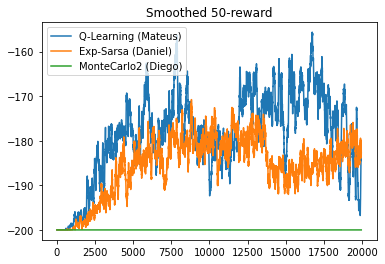

<Figure size 1008x576 with 0 Axes>

Summary for Q-Learning (Mateus)
 - sum rewards (all episodes): -3574794.6666666665

Summary for Exp-Sarsa (Daniel)
 - sum rewards (all episodes): -3712483.333333334

Summary for MonteCarlo2 (Diego)
 - sum rewards (all episodes): -4000000.0



In [7]:
ENV = gym.make("MountainCar-v0")
NUM_EPISODES = 20000

results = []

'''
Mateus {'bins1': 56, 'bins2': 51, 'epsilon': 0.01186126148733685, 'learning_rate': 0.6912469478373227}
Daniel Rosa {'bins1': 54, 'bins2': 70, 'epsilon': 0.13703891101977922, 'learning_rate': 0.6792059384074097}
Diego Soares {bins1': 65, 'bins2': 46, 'epsilon': 0.09108892703810256, 'learning_rate': 0.27627593841593145}
'''

wrapped_env = DiscreteObservationWrapper(ENV, [56,51])
results.append( repeated_exec(3, f"Q-Learning (Mateus)", run_qlearning, wrapped_env, NUM_EPISODES, 0.691, 0.95, 0.011) )
clear_output()

wrapped_env = DiscreteObservationWrapper(ENV, [54,70])
results.append( repeated_exec(3, f"Exp-Sarsa (Daniel)", run_expected_sarsa, wrapped_env, NUM_EPISODES, 0.679, 0.95, 0.137) )
clear_output()

wrapped_env = DiscreteObservationWrapper(ENV, [65,46])
results.append( repeated_exec(3, f"MonteCarlo2 (Diego)", run_montecarlo2, wrapped_env, NUM_EPISODES, 0.276, 2.28, 0.091) )
clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)


### CartPole (contínuo)

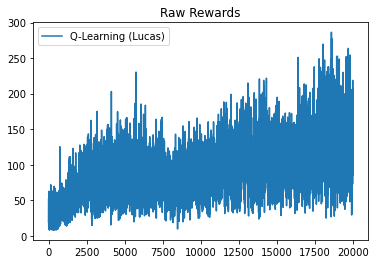

<Figure size 1008x576 with 0 Axes>

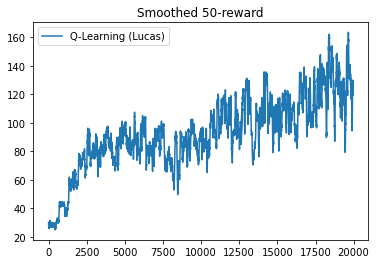

<Figure size 1008x576 with 0 Axes>

Summary for Q-Learning (Lucas)
 - sum rewards (all episodes): 1841277.3333333335



In [5]:

ENV = gym.make("CartPole-v1")
ENV = PunishEarlyStop(ENV)
NUM_EPISODES = 20000

results = []

#'bin1': 93,
#'bin2': 43,
#'bin3': 6,
#'bin4': 76,
#'epsilon': 0.015607854707332426,
#'gamma': 0.9134000716662984,
#'learning_rate': 0.11056680467861989}
wrapped_env = DiscreteObservationWrapper(ENV, [93,43,6,76])
results.append( repeated_exec(3, f"Q-Learning (Lucas)", run_qlearning, wrapped_env, NUM_EPISODES, 0.110, 0.913, 0.015) )
clear_output()

#MELHORES PARÂMETROS:
#?
wrapped_env = DiscreteObservationWrapper(ENV, [54,70])
#results.append( repeated_exec(3, f"Exp-Sarsa (Savio)", run_expected_sarsa, wrapped_env, NUM_EPISODES, 0.679, 0.95, 0.137) )
clear_output()

#MELHORES PARÂMETROS:
#?
wrapped_env = DiscreteObservationWrapper(ENV, [65,46])
#results.append( repeated_exec(3, f"MonteCarlo2 (Giulia)", run_montecarlo2, wrapped_env, NUM_EPISODES, 0.276, 2.28, 0.091) )
clear_output()

plot_multiple_results(results, cumulative=False, x_log_scale=False)